In [1]:
from keras.layers import Dense
%matplotlib inline
import keras
from keras.models import Sequential
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import scipy
import math
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import load_model
from sklearn.metrics import confusion_matrix

from IPython.display import clear_output

Using TensorFlow backend.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(800/96, 800/96), dpi=96)
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show()
        
plot = PlotLearning()

In [3]:
path_text='../Text-detection-in-natural-scene-images-dataset/text or no text dataset/english_base_1/'
path_notext = '../Text-detection-in-natural-scene-images-dataset/text or no text dataset/no_text_base_1/'

files_text_png = list(Path(path_text).glob('**/*.png'))
files_text_jpg = list(Path(path_text).glob('**/*.jpg'))
files_text = files_text_png + files_text_jpg

files_notext_png = list(Path(path_notext).glob('**/*.png'))
files_notext_jpg = list(Path(path_notext).glob('**/*.jpg'))

files_notext = files_notext_png + files_notext_jpg

# files = os.listdir(path_text)[1:]
# files_notext = os.listdir(path_notext)[1:]

print(len(files_text))
print(len(files_notext))
#print(files)

text_data = pd.DataFrame(np.empty((1,1024)))
non_text_data = pd.DataFrame(np.empty((1,1024)))

8467
13321


In [4]:
i=0
for images in files_text:
    img = np.asarray(Image.open(images).resize((32,32),Image.ANTIALIAS))
    text_data.loc[i,:] = img.ravel()
    i+=1
    #print("i *** in text images", i)
print("Done for text images")
i=0
for images in files_notext:
    img = np.asarray(Image.open(images).convert('L').resize((32,32),Image.ANTIALIAS))
    non_text_data.loc[i,:] = img.ravel()
    i+=1
    #print("i *** in nontext images", i)

print("Done for non text images")

Done for text images
Done for non text images


In [15]:
non_text_data['text_label'] = 0
text_data['text_label'] = 1

In [16]:
data = pd.concat([text_data,non_text_data])

In [17]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(data.iloc[:,:1024],data['text_label'],test_size=0.1)

In [18]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
train_x = sc_x.fit_transform(train_x)
test_x = sc_x.transform(test_x)

from sklearn.externals import joblib
joblib.dump(sc_x , './model_8k_13k_30e.pkl')

['./model_8k_13k_30e.pkl']

# Using CNN for the classification algorithm

In [19]:
train_x1 = train_x.reshape((train_x.shape[0],32,32,1))
test_x1 = test_x.reshape((test_x.shape[0],32,32,1))

In [20]:
clf1 = Sequential()
clf1.add(Convolution2D(32,(3,3),input_shape=(32,32,1),activation='relu'))
clf1.add(MaxPooling2D(2,2))
clf1.add(Convolution2D(128,(3,3),activation='relu'))
clf1.add(MaxPooling2D(2,2))
clf1.add(Convolution2D(128,(3,3),activation='relu'))
clf1.add(MaxPooling2D(2,2))
clf1.add(Flatten())
clf1.add(Dense(activation='relu',units=500,kernel_initializer='uniform'))
clf1.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
clf1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

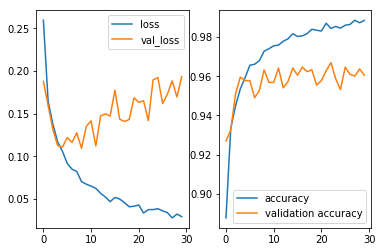

In [21]:
clf1.fit(train_x1, train_y, epochs=30, validation_data=(test_x1, test_y), callbacks=[plot], verbose=0)
clf1.save('./model_8k_13k_30e.h5')

In [22]:
y_pred1 = np.around(clf1.predict(test_x1))

In [23]:
confusion_matrix(test_y,y_pred1)

array([[1286,   34],
       [  52,  807]])

# Now we'll try to apply this model on a few images

In [23]:
def binarize(file=None):
#     img = cv2.imread('../Text-detection-in-natural-scene-images-dataset/text or no text dataset/testing/4833.jpg', 0)
    # Number of rows and columns
    import scipy
    
    img = cv2.imread(file, 0)
    rows = img.shape[0]
    cols = img.shape[1]

    # Convert image to 0 to 1, then do log(1 + I)
    img_log = np.log1p(np.array(img, dtype="float") / 255)

    # Create Gaussian mask of sigma = 10
    M = 2*rows + 1
    N = 2*cols + 1
    sigma = 10
    (X,Y) = np.meshgrid(np.linspace(0,N-1,N), np.linspace(0,M-1,M))
    center_x = np.ceil(N/2)
    center_y = np.ceil(M/2)
    gaussian_numerator = (X - center_x)**2 + (Y - center_y)**2

    # Low pass and high pass filters
    h_low = np.exp(-gaussian_numerator / (2*sigma*sigma))
    h_high = 1 - h_low

    # Move origin of filters so that it's at the top left corner to
    # match with the input image
    h_low_shift = scipy.fftpack.ifftshift(h_low.copy())
    h_high_shift = scipy.fftpack.ifftshift(h_high.copy())


    # Filter the image and crop
    image_filter = scipy.fftpack.fft2(img_log.copy(), (M,N))
    image_outlow = scipy.real(scipy.fftpack.ifft2(image_filter.copy() * h_low_shift, (M,N)))
    image_outhigh = scipy.real(scipy.fftpack.ifft2(image_filter.copy() * h_high_shift, (M,N)))

    # Set scaling factors and add
    gamma1 = 0.3
    gamma2 = 1.5
    image_out = gamma1*image_outlow[0:rows,0:cols] + gamma2*image_outhigh[0:rows,0:cols]

    # Anti-log then rescale to [0,1]
    image_hmf = np.expm1(image_out)
    image_hmf = (image_hmf - np.min(image_hmf)) / (np.max(image_hmf) - np.min(image_hmf))
    image_hmf2 = np.array(255*image_hmf, dtype="uint8")
    
    print("Median, Mean", np.median(image_hmf2, axis=(0,1)), np.mean(image_hmf2, axis=(0,1)))
    mean_value = np.mean(image_hmf2, axis=(0,1))

    # Threshold the image - Anything below intensity (Random) gets set to white
    
    # threshold values = [110, 127]
    image_thresh = image_hmf2 < 110
    image_thresh = 255*image_thresh.astype("uint8")
    
    if mean_value < 110:
        cc = cv2.connectedComponents(np.uint8(cv2.bitwise_not(image_thresh)))[1]
    else:
        cc = cv2.connectedComponents(np.uint8(image_thresh))[1]
 
    fig, axes = plt.subplots(ncols=4, figsize=(20, 10))
    ax = axes.ravel()
    
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    ax[1].imshow(image_hmf2, cmap=plt.cm.gray)
    ax[1].set_title('Homographic')
    ax[1].axis('off')
    
    ax[2].imshow(image_thresh, cmap=plt.cm.gray)
    ax[2].set_title('Threshold')
    ax[2].axis('off')
    
    ax[3].imshow(cc, cmap=plt.cm.gray)
    ax[3].set_title('CC')
    ax[3].axis('off')

    plt.show()
    
    return cc

In [24]:
# img = cv2.imread(,0)

#a = input('Bright text on dark background? Press Y/y for yes and any other key for no.' )
# if a=='y' or a=='Y':
#     otsu_1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# #     th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,25,3)
# else:
#     otsu_1 = 255-cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# #     th2 = 255- cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,25,3)

file = '../Text-detection-in-natural-scene-images-dataset/text or no text dataset/testing/28320.jpg'
# otsu_1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,25,3)
# connected components
cc = binarize(file)
# cc  = cv2.connectedComponents(np.uint8(th2))[1]

# creating imgage for every single label in the connected components
con_img = {}
for label in np.unique(cc[cc>0]):
    image = np.zeros(cc.shape)
    indices = np.where(cc==label)
    image[indices] = 1
    con_img[label] = image
    

# plt.savefig('plot_3.jpg')

# plt.figure(figsize=[20,10])
# plt.subplot(1,3,1)
# plt.imshow(img)

# plt.subplot(1,3,2)
# plt.imshow(otsu_1)

# plt.subplot(1,3,3)
# plt.imshow(cc)


AttributeError: module 'scipy' has no attribute 'fftpack'

NameError: name 'cc' is not defined

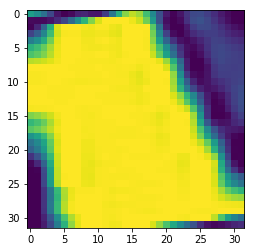

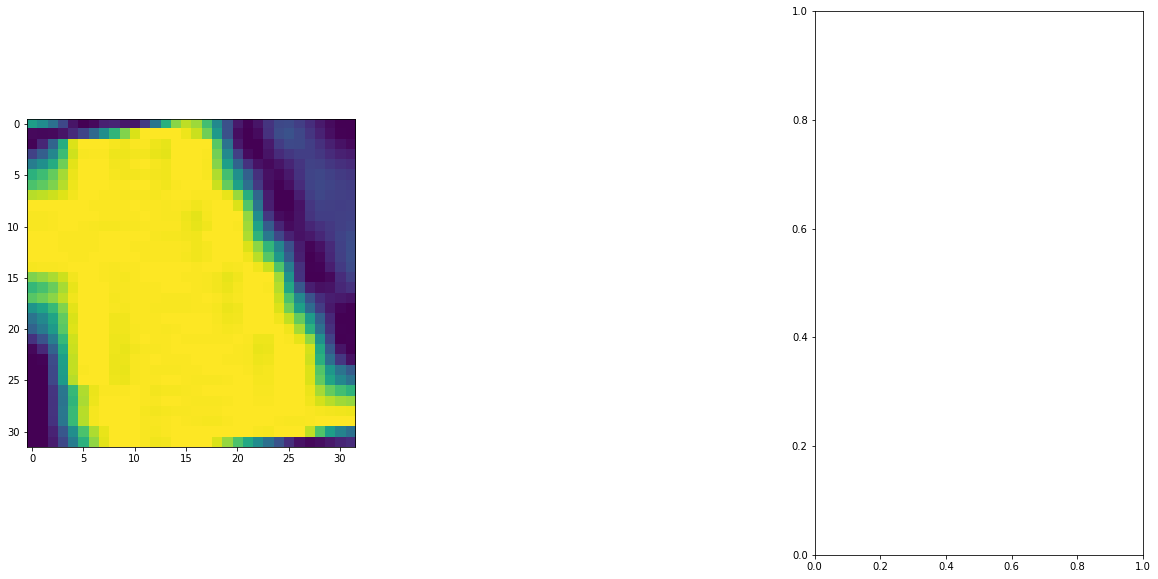

In [18]:
# img    =    cv2.imread('../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/1.jpg',0)
plt.imshow(img)
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
plt.imshow(img)

# plt.subplot(1,3,2)
# plt.imshow(otsu_1)

plt.subplot(1,3,3)
plt.imshow(cc)

#print(con_img)

/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


ValueError: tile cannot extend outside image

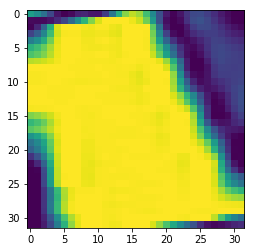

In [64]:
plt.imshow(img)

tot1=0
i=1
mask = {}
i=1
model = load_model('./model_30k_20k.h5')
loaded_scaler = joblib.load('./model_30k_20k.pkl')
for elem in con_img.keys():
    x,y,w,h = cv2.boundingRect(np.uint8(con_img[elem]))
    #print("****", x, y, w, h)
    imng = img[y:y+h,x:x+w]
    imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
    imng = loaded_scaler.transform(imng)
    imng = imng.reshape((1,32,32,1))
#     print(elem,np.around(classifier.predict(imng)))
    if np.around(model.predict(imng)) == 1.0:
        print('yuhoo')
        tot1+=con_img[elem]
#         mask[i]=con_img[elem]
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        i+=1

tot1 = cv2.bitwise_not(tot1)

plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(tot1,'gray')